In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

 92% 60.0M/65.2M [00:02<00:00, 35.6MB/s]
100% 65.2M/65.2M [00:02<00:00, 27.1MB/s]


In [ ]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Lambda, Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

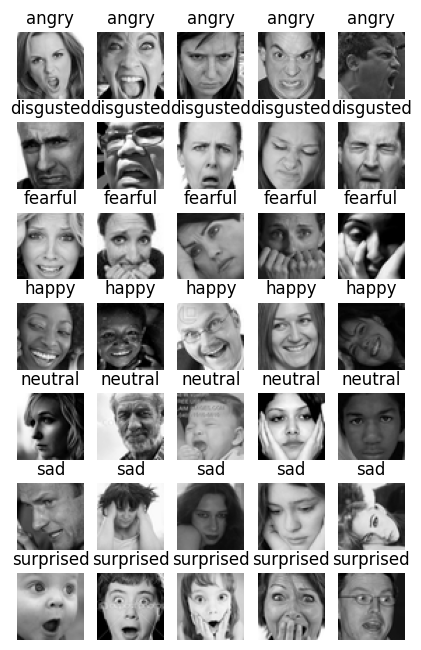

In [ ]:
# index = 1
# plt.figure(figsize=(10, 5))
# for classname in classes:
#     class_dir = os.path.join(train_dir, classname)

#     for filename in os.listdir(class_dir)[:1]:
#         image = cv.imread(os.path.join(class_dir, filename))

#         plt.subplot(1, len(classes), index)
#         plt.title(classname)
#         plt.imshow(image, cmap="gray")
#         plt.axis("off")

#         index += 1

# plt.show()
index = 1
plt.figure(figsize=(5, 8))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)

    for i, filename in enumerate(os.listdir(class_dir)[:5]):
        image = cv.imread(os.path.join(class_dir, filename))
        plt.subplot(len(classes), 5, index)
        plt.title(classname, fontsize=12)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

        index += 1

plt.show()

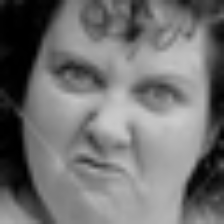

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)

    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)

    total_image_per_class.append(len(os.listdir(class_dir)))

data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

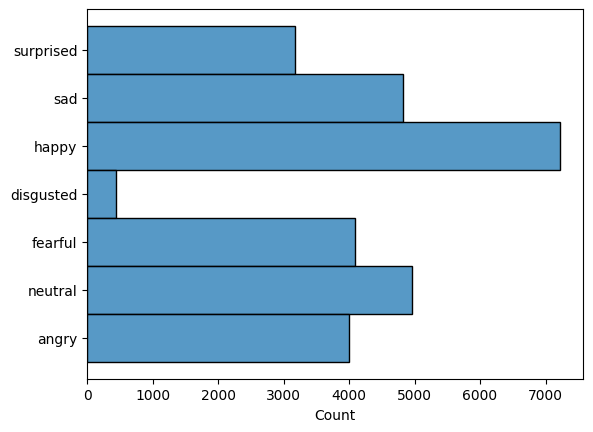

In [ ]:
sns.histplot(data=total_image_per_class, y=image_classes)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)
vgg_model = vgg.output
vgg_model = Flatten(name="flatten")(vgg_model)
vgg_model = Dense(512, activation="relu")(vgg_model)
vgg_model = Dropout(0.5)(vgg_model)
vgg_model = Dense(7, activation="softmax")(vgg_model)
model = Model(inputs=vgg.input, outputs=vgg_model)
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in vgg.layers:
	layer.trainable = False

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 367s 496ms/step - loss: 1.7953 - accuracy: 0.2612 - val_loss: 1.7020 - val_accuracy: 0.3181
Epoch 2/20
718/718 [==============================] - 351s 488ms/step - loss: 1.6960 - accuracy: 0.3245 - val_loss: 1.6346 - val_accuracy: 0.3555
Epoch 3/20
718/718 [==============================] - 347s 483ms/step - loss: 1.6449 - accuracy: 0.3553 - val_loss: 1.5935 - val_accuracy: 0.4039
Epoch 4/20
718/718 [==============================] - 351s 489ms/step - loss: 1.6086 - accuracy: 0.3724 - val_loss: 1.5872 - val_accuracy: 0.3799
Epoch 5/20
718/718 [==============================] - 351s 489ms/step - loss: 1.5823 - accuracy: 0.3859 - val_loss: 1.5382 - val_accuracy: 0.4079
Epoch 6/20
718/718 [==============================] - 351s 490ms/step - loss: 1.5558 - accuracy: 0.3986 - val_loss: 1.5255 - val_accuracy: 0.4142
Epoch 7/20
718/718 [==============================] - 356s 496ms/step - loss: 1.5321 - accuracy: 0.4118 - val_loss: 1.5075 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

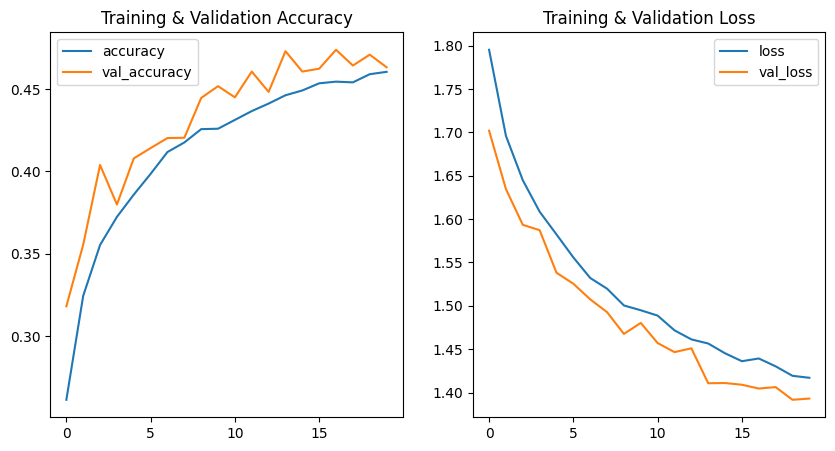

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 91s 403ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.48      0.19      0.27       958
           1       0.00      0.00      0.00       111
           2       0.31      0.26      0.28      1024
           3       0.50      0.84      0.63      1774
           4       0.48      0.34      0.40      1233
           5       0.37      0.40      0.39      1247
           6       0.64      0.57      0.61       831

    accuracy                           0.47      7178
   macro avg       0.40      0.37      0.37      7178
weighted avg       0.45      0.47      0.44      7178



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.465589300640847
recall:  0.465589300640847
precision:  0.45442315140576367
f1-score:  0.4378341066696876
Result =  0.45585896483928634


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for layer in vgg.layers:
	layer.trainable = True

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 448s 610ms/step - loss: 1.3322 - accuracy: 0.4919 - val_loss: 1.2642 - val_accuracy: 0.5172
Epoch 2/20
718/718 [==============================] - 432s 601ms/step - loss: 1.2384 - accuracy: 0.5335 - val_loss: 1.2357 - val_accuracy: 0.5259
Epoch 3/20
718/718 [==============================] - 430s 599ms/step - loss: 1.1919 - accuracy: 0.5493 - val_loss: 1.1542 - val_accuracy: 0.5605
Epoch 4/20
718/718 [==============================] - 444s 619ms/step - loss: 1.1468 - accuracy: 0.5667 - val_loss: 1.1163 - val_accuracy: 0.5755
Epoch 5/20
718/718 [==============================] - 429s 597ms/step - loss: 1.1182 - accuracy: 0.5804 - val_loss: 1.0887 - val_accuracy: 0.5919
Epoch 6/20
718/718 [==============================] - 433s 603ms/step - loss: 1.0827 - accuracy: 0.5903 - val_loss: 1.0677 - val_accuracy: 0.5921
Epoch 7/20
718/718 [==============================] - 429s 597ms/step - loss: 1.0571 - accuracy: 0.5982 - val_loss: 1.0784 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

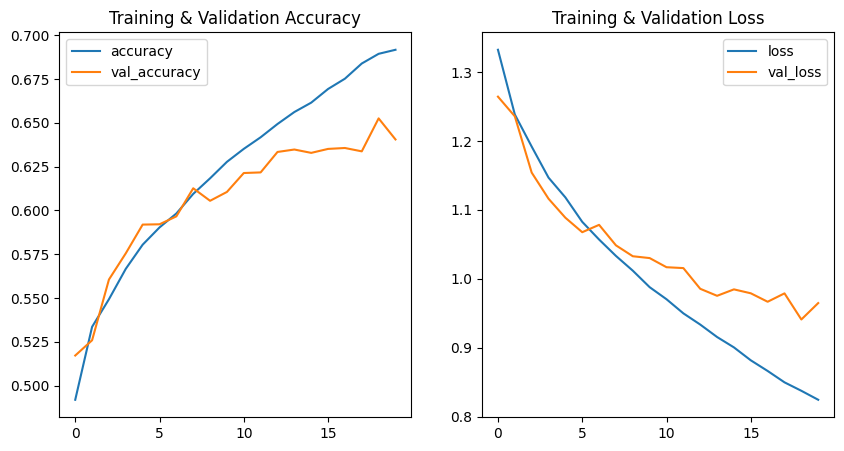

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 84s 374ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55       958
           1       0.63      0.35      0.45       111
           2       0.47      0.42      0.44      1024
           3       0.86      0.85      0.85      1774
           4       0.63      0.61      0.62      1233
           5       0.48      0.60      0.53      1247
           6       0.78      0.71      0.74       831

    accuracy                           0.64      7178
   macro avg       0.63      0.58      0.60      7178
weighted avg       0.65      0.64      0.64      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.6382000557258289
recall:  0.6382000557258289
precision:  0.6450240692681222
f1-score:  0.6392770165828513
Result =  0.6401752993256579
